In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses


Bad key savefig.frameon in file C:\Users\pedem\anaconda3\envs\tensorflowenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\pedem\anaconda3\envs\tensorflowenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\pedem\anaconda3\envs\tensorflowenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stde

In [2]:
# Load Data
# ---
tickers = ['BTC-USD']

start = dt.datetime(2016,1,1)
end = dt.datetime(2021,3,15)

data = web.DataReader(tickers, 'yahoo', start, end)

In [3]:
# Prepare Data (Scaling)
# ---
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # Only closing price

prediction_days = 20  # Number of days you want to look into the past.

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):  # Create training sets.
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
# Build the Model
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1))) # Can change the number of units to increase or decrease training.
model.add(Dropout(0.2))
model.add(LSTM(units = 150, return_sequences = True)) # Can change the number of units to increase or decrease training.
model.add(Dropout(0.2))
model.add(LSTM(units = 150)) # Can change the number of units to increase or decrease training.
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing value.

model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
model_history = model.fit(x_train, y_train, epochs=80, batch_size = 64, shuffle = False) # Can tweak batch_size (number of samples looked at one time) or epochs.

Epoch 1/80
30/30 [==============================] - 4s 34ms/step - loss: 0.0370
Epoch 2/80
30/30 [==============================] - 1s 34ms/step - loss: 0.1068
Epoch 3/80
30/30 [==============================] - 1s 34ms/step - loss: 0.0678
Epoch 4/80
30/30 [==============================] - 1s 36ms/step - loss: 0.0660
Epoch 5/80
30/30 [==============================] - 1s 34ms/step - loss: 0.1008
Epoch 6/80
30/30 [==============================] - 1s 35ms/step - loss: 0.0532
Epoch 7/80
30/30 [==============================] - 1s 34ms/step - loss: 0.0801
Epoch 8/80
30/30 [==============================] - 1s 35ms/step - loss: 0.0278
Epoch 9/80
30/30 [==============================] - 1s 34ms/step - loss: 0.0640
Epoch 10/80
30/30 [==============================] - 1s 33ms/step - loss: 0.0570
Epoch 11/80
30/30 [==============================] - 1s 35ms/step - loss: 0.0177
Epoch 12/80
30/30 [==============================] - 1s 34ms/step - loss: 0.0397
Epoch 13/80
30/30 [==================

In [5]:
# Load Test Data
# ---
test_start = dt.datetime(2021,3,16)  # Gather data not available to the model
test_end = dt.datetime.now()

test_data = web.DataReader(tickers, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [6]:
# Make Predictions on Test Data
# ---
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x- prediction_days:x,  0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

<function matplotlib.pyplot.show(close=None, block=None)>

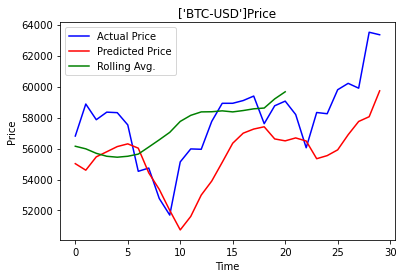

In [7]:
rolling = np.array(pd.DataFrame(actual_prices).rolling(10).mean().dropna())
# Plot Test Predictions
plt.plot(actual_prices, color = 'blue', label = "Actual Price")
plt.plot(predicted_prices, color = 'red', label = "Predicted Price")
plt.plot(rolling, color = 'green', label = "Rolling Avg.")
plt.title(str(tickers) + "Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show

In [8]:
real_data = [model_inputs[len(model_inputs) + 1  - prediction_days: len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print("Prediction:", prediction)

Prediction: [[60786.43]]
